# Ablation laser

Pulse energy measured with a Thorlabs ES245C Pyroelectric Energy Sensor (Ceramic Coating, 0.185 - 25 µm, 15 J).

Import required packages, then connect to the VISA resource manager to find out what the addresses of the laser and the scope are:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import visa
from time import sleep
from importlib import reload
from scipy.signal import find_peaks_cwt
import h5py

import sys
sys.path.insert(0, r'..\drivers')
import CFR200
import Tektronix2014B

rm = visa.ResourceManager()
rm.list_resources()

('USB0::0x0699::0x0368::C100692::INSTR', 'ASRL1::INSTR', 'ASRL3::INSTR')

Set the correct addresses:

In [5]:
laser_addr = 'COM3'
scope_addr = 'USB0::0x0699::0x0368::C100692::INSTR'

### Laser power vs QS–flashlamp delay

Set the parameters of the scan:

In [6]:
delays  = np.arange(100,250,2)
num_acq = 25

Turn on the flashlamp and automatic Q-switching, then loop through all the required delays, measuring (then averaging over) the energy of `num_acq` pulses for each value of the delay:

In [8]:
voltages, std_voltages = [], []

with CFR200.CFR200(rm, laser_addr) as laser, \
    Tektronix2014B.Tektronix2014B(rm, scope_addr) as scope:
        scope.SetImmedMeasType('pk2pk')
        scope.SetAcqState('on')
        laser.SetQSF10(10)

        laser.ActivateFlashlampAutoFire();
        sleep(4)
        laser.StartQS()

        for delay in delays:
            laser.SetQSFlashlampDelay(delay);

            # measure pulse energy for num_acq pulses
            values = []
            for i in range(num_acq):
                scope.SetAcqState('on')
                sleep(0.5)            
                values.append( scope.QueryImmedMeasValue() )
            
            # calculate mean and stdev
            voltages.append(np.mean(values))
            std_voltages.append(np.std(values))

        laser.StopQS()
        laser.StopFlashlampAutoFire();

Plot the result in sensible units:

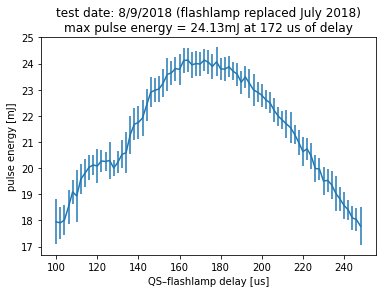

In [9]:
energies = 1000*np.array(voltages)/8.31
std_energies = 1000*np.array(std_voltages)/8.31

plt.errorbar(delays, energies, std_energies)
plt.xlabel("QS–flashlamp delay [us]")
plt.ylabel("pulse energy [mJ]")
plt.title("test date: 8/9/2018 (flashlamp replaced July 2018)"+\
          "\nmax pulse energy = " +\
          str( round(energies[np.argmax(energies)],2) ) +\
              "mJ at " + str( delays[np.argmax(energies)] ) +\
              " us of delay");

Store results in an HDF5 file:

In [11]:
with h5py.File("../../data/ablation_laser.hdf5", "w") as f:
    grp = f.create_group("power vs QS-flashlamp delay")
    dset = grp.create_dataset(
        "test date: 8-9-2018 (flashlamp replaced July 2018)",
        data=[delays, energies, std_energies]    )
    dset.attrs["xlabel"] = "QS–flashlamp delay [us]"
    dset.attrs["ylabel"] = "pulse energy [mJ]"
    dset.attrs["QS freq"] = "10 Hz"

### Laser power vs Q-switching frequency

Set scan parameters:

In [18]:
QSff    = np.arange(4,25,1)
num_acq = 25

Seeing that a QS–flashlamp delay of about 160 ms is optimal, we can now scan over the QS frequency values, again taking `num_acq` measurements for each value in `QSff`:

In [35]:
voltages_QSf, std_voltages_QSf = [], []

with CFR200.CFR200(rm, laser_addr) as laser, \
    Tektronix2014B.Tektronix2014B(rm, scope_addr) as scope:
        scope.SetImmedMeasType('pk2pk')
        scope.SetAcqMode('sample')
        scope.SetAcqState('on')
        laser.SetQSFlashlampDelay(160);
        
        laser.ActivateFlashlampAutoFire();
        sleep(4)
        
        for QSf in QSff:
            laser.SetQSF10(QSf)
            laser.StartQS()

            values = []
            for i in range(num_acq):
                scope.SetAcqState('on')
                sleep(0.5)            
                values.append( scope.QueryImmedMeasValue() )
            
            laser.StopQS()
            
            voltages_QSf.append(np.mean(values))
            std_voltages_QSf.append(np.std(values))

        laser.StopFlashlampAutoFire();

Plot the result in sensible units:

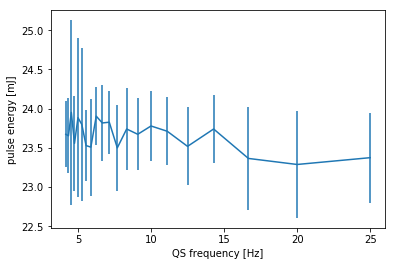

In [36]:
plt.errorbar(100/QSff,
             1000*np.array(voltages_QSf)/8.31,
             yerr=1000*np.array(std_voltages_QSf)/8.31);
plt.xlabel("QS frequency [Hz]");
plt.ylabel("pulse energy [mJ]");
plt.show();

### Beam profiling

Set laser QS frequency to 25 Hz, and the QS–flashlamp delay to 175 us. Then move a razor blade in front of the laser and measure pulse energy (averaged over as many pulses as fit in the scope screen, i.e. 25 of them) as a function of the blade position.

In [ ]:
xx = np.arange(0,80,2.5)

voltages_x, std_voltages_x, num_pulses = [], [], []
with Tektronix2014B.Tektronix2014B(rm, scope_addr) as scope:
        for x in xx:
            print(x)
            input()
            
            # measure
            scope.SetAcqState('on')
            [x, y, xunit, yunit] = scope.get_waveform('CH1')
            
            # analyze peaks
            peaks = y[ find_peaks_cwt(y, [10]) ]
            num_pulses.append(len(peaks))
            voltages_x.append(np.mean(peaks))
            std_voltages_x.append(np.std(peaks))

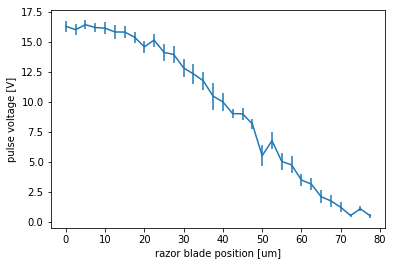

In [39]:
plt.errorbar(xx, 1000*np.array(voltages_x)/8.31, yerr=1000*np.array(std_voltages_x)/8.31)
plt.xlabel("razor blade position [um]");
plt.ylabel("pulse voltage [V]");

Now translate the razor blade 4 ft away from the laser, and repeat the measurement.

In [ ]:
xx2 = np.arange(0,150,2.5)

voltages_x2, std_voltages_x2, num_pulses2 = [], [], []
with Tektronix2014B.Tektronix2014B(rm, scope_addr) as scope:
        for x in xx2:
            print(x)
            input()
                
            # measure
            scope.SetAcqState('on')
            [x, y, xunit, yunit] = scope.get_waveform('CH1')
            
            # analyze peaks
            peaks = y[ find_peaks_cwt(y, [10]) ]
            num_pulses2.append(len(peaks))
            voltages_x2.append(np.mean(peaks))
            std_voltages_x2.append(np.std(peaks))

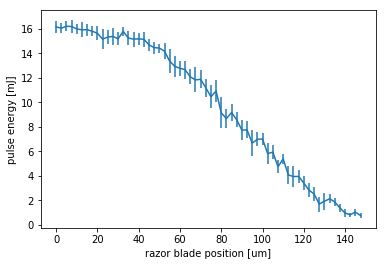

In [11]:
plt.errorbar(xx2, 1000*np.array(voltages_x2)/8.31, yerr=1000*np.array(std_voltages_x2)/8.31)
plt.xlabel("razor blade position [um]");
plt.ylabel("pulse energy [mJ]");

It seems the beam width has roughly doubled in the 4ft. The beam waist is then, very approximately:

$w_0 = \sqrt{\frac{z_\text{R}\lambda}{\pi}}\approx1\text{mm}$,

where $z_\text{R}\approx4'$ is the Rayleigh range, and for Nd:YAG, the wavelength is $\lambda\approx1064\text{nm}$.